In [1]:
import warnings
warnings.filterwarnings("ignore")

# 1º: Create the Molecule and Hamiltonian

In the code cells below, we create the molecular geometry of H2 with the radial distance of 1,401 a.u. with the optimal internuclear distance of Kolos and Wolniewicz. We will use the STO-3G minimal basis set by importing the parameters of the basis set exchange functions. Pennylane allows us to construct the Hamiltonian from the second quantization with the Jordan-Wigner transformation.

In [2]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import torch

symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0], [0.0, 0.0, 1.401]], requires_grad = False)
molecule = qml.qchem.Molecule(symbols, coordinates, basis_name='STO-3G', load_data=True, unit='bohr')
H, qubits = qml.qchem.molecular_hamiltonian(molecule)

print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is  -0.09883485860187924 * I([0, 1, 2, 3]) + 0.17120123803197834 * Z(0) + 0.17120123803197845 * Z(1) + 0.16862327620358059 * (Z(0) @ Z(1)) + -0.22279639115527738 * Z(2) + 0.12054612718324412 * (Z(0) @ Z(2)) + 0.16586801098505832 * (Z(1) @ Z(2)) + 0.045321883801814206 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.045321883801814206 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.045321883801814206 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.045321883801814206 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.22279639115527738 * Z(3) + 0.16586801098505832 * (Z(0) @ Z(3)) + 0.12054612718324412 * (Z(1) @ Z(3)) + 0.17434948668373768 * (Z(2) @ Z(3))


# 2º: Configure the Simulator

In the cells below, we have configured a noise-free qiskit.aer simulator with the pennylane-qiskit plugin. Our purpose is to simulate UCCSD with the ground state and doubly excited state through Givens rotations, provided by Pennylane. The purpose of the circuit is to calculate the expected value of the Hamiltonian.

In [3]:
dev = qml.device("qiskit.aer", wires=qubits, backend='statevector_simulator',shots=None)

In [4]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [5]:
@qml.qnode(dev, interface="pytorch")
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param[0], wires=[0, 1, 2, 3])
    return qml.expval(H)

In [6]:
def cost_fn(param):
    return circuit(param, wires=range(qubits))

# 3º: Configure the optimizer and run the circuit

In the code cells below, we configure the L-BFGS optimizer, a very common optimizer that works well in noise-free environments. However, in the slightest presence of noise, this optimizer fails to reach convergence. We configure it with 250 steps (converging in 144 steps) and a learning rate of 0.05. We also pass the parameter angles that will be optimized. We run the circuit until it reaches convergence (minimum).

In [44]:
theta = torch.nn.Parameter(torch.tensor([0.0]))

optimizer = torch.optim.LBFGS([theta], lr=0.05, max_iter=250, tolerance_grad=1e-8)

In [45]:
energies = []
thetas = []

def closure():
    optimizer.zero_grad()
    loss = cost_fn(theta)
    loss.backward()
    energies.append(loss.item())
    thetas.append(float(theta.data[0]))
    return loss

optimizer.step(closure)

print("\nFinal Energy Estimate:", cost_fn(theta).item())
print("Optimal Parameter:", theta.detach().numpy())


Final Energy Estimate: -1.1372704134605531
Optimal Parameter: [0.22597922]


In [46]:
print(f"Nunber of Calculated Energies (VQE): {len(energies)}")
print(f"Number of Calculated Parameters: {len(thetas)}")

Nunber of Calculated Energies (VQE): 144
Number of Calculated Parameters: 144


# 4º: Collect and Analyze Results

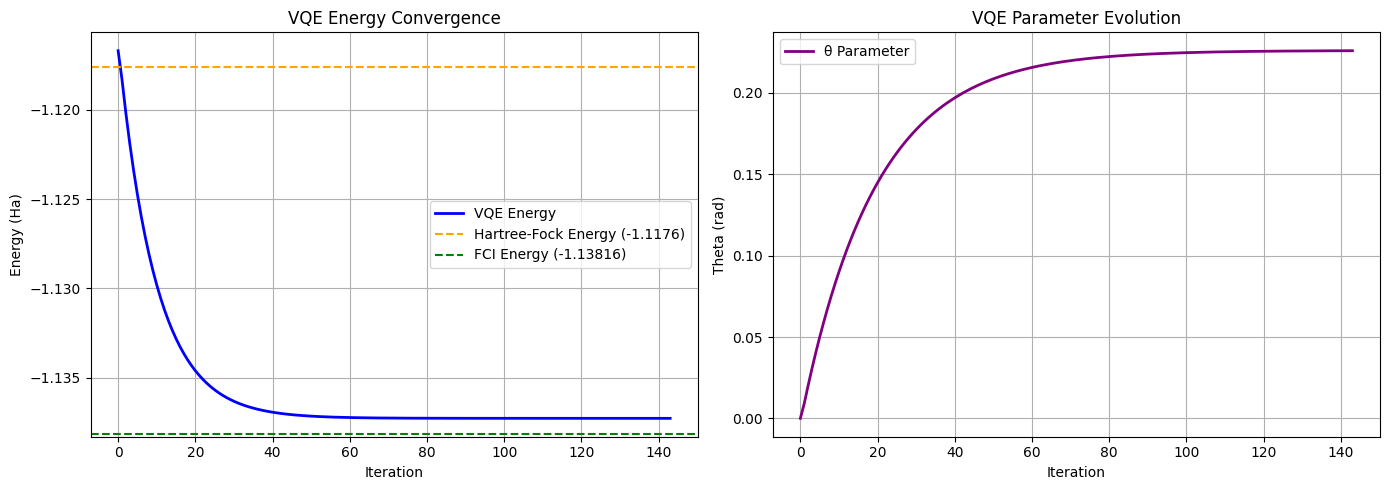

In [49]:
hf_energy = -1.1176
fci_energy = -1.13816

steps = list(range(len(energies)))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(steps, energies, label='VQE Energy', color='blue', linewidth=2)
axs[0].axhline(hf_energy, color='orange', linestyle='--', label=f'Hartree-Fock Energy ({hf_energy})')
axs[0].axhline(fci_energy, color='green', linestyle='--', label=f'FCI Energy ({fci_energy})')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Energy (Ha)')
axs[0].set_title('VQE Energy Convergence')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(steps, thetas, label='θ Parameter', color='purple', linewidth=2)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Theta (rad)')
axs[1].set_title('VQE Parameter Evolution')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
